# Car Brands Classification (Training, Testing & Inference )

### *This notebook contains training, testing and infering the 3 URLS and generating similar images as mentioned in the task requirements*

In [1]:
import tensorflow as tf
from tensorflow.keras import applications

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from keras_tqdm import TQDMNotebookCallback
from livelossplot import PlotLossesKeras
from livelossplot.inputs.tf_keras import PlotLossesCallback


from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dropout, Flatten, Dense, Conv2D, 
                          Activation, MaxPooling2D)

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os, glob

#from tqdm import tqdm
#from tqdm import tqdm_notebook
#from tqdm.notebook import tqdm
#from tqdm.keras import TqdmCallback


from collections import Counter
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import shutil
import keras
import urllib

from tensorflow.keras.applications.resnet50 import ResNet50
from livelossplot import PlotLossesKeras
from livelossplot.inputs.tf_keras import PlotLossesCallback

import matplotlib.pyplot as plt
%matplotlib inline

## Training 

In [2]:
#Importing images from training and validation datasets
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)


test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    'audi_benz_bmw_train/',
    target_size=(150, 150),
    batch_size=32,
    shuffle=True,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    'audi_benz_bmw_valid/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

Found 707 images belonging to 3 classes.
Found 107 images belonging to 3 classes.


In [90]:
#defining the model architecture
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu')) #tanh
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu')) #tanh
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(96))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3)) # binary
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

**Don't run the cell below as it starts training. model is loaded from .h5 file in the later cell for inference**

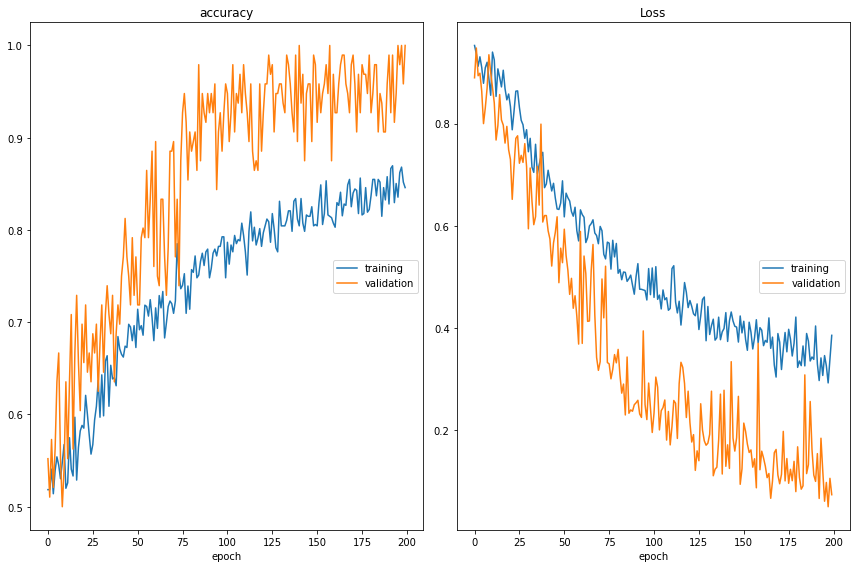

accuracy
	training         	 (min:    0.514, max:    0.870, cur:    0.846)
	validation       	 (min:    0.500, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.292, max:    0.953, cur:    0.386)
	validation       	 (min:    0.050, max:    0.948, cur:    0.074)


In [22]:
model.fit_generator(
    train_generator,
    steps_per_epoch= 707 // 32, # give me more data
    epochs=200,
    #callbacks=[TQDMNotebookCallback()],
    #callbacks=tf.keras.callbacks.Callback(),
    callbacks=[PlotLossesCallback()],
    verbose=0,
    validation_data=validation_generator,
    validation_steps= 107 // 32)

In [91]:
model.save('model_carbrand_1.h5')

# Testing

In [3]:
#loading the model for inference
from tensorflow.keras.models import load_model
model=load_model('model_carbrand.h5')

In [4]:
#loading test images
test_generator = test_datagen.flow_from_directory(
    'audi_benz_bmw_test/',
    target_size=(150, 150),
    batch_size=1, shuffle=False,
    class_mode='categorical')
preds = model.predict_generator(generator=test_generator, steps=15)

Found 15 images belonging to 3 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


In [5]:
test_generator

In [6]:
#converting probabilities from scientific to decimal values while printing
np.set_printoptions(suppress=True)
preds*100

array([[96.53291   ,  2.7144136 ,  0.7526671 ],
       [99.540565  ,  0.43393666,  0.02550134],
       [46.158756  , 23.569403  , 30.271847  ],
       [92.121956  ,  7.826082  ,  0.05195569],
       [12.241549  , 39.090675  , 48.667778  ],
       [19.062439  , 70.54783   , 10.389727  ],
       [12.455553  , 82.08698   ,  5.4574604 ],
       [14.951594  , 37.541172  , 47.50724   ],
       [ 3.8777232 , 19.27125   , 76.85103   ],
       [51.071995  ,  0.00001044, 48.92799   ],
       [ 0.01415706, 99.86646   ,  0.11938819],
       [ 1.1079046 ,  0.03628822, 98.855804  ],
       [30.945427  , 18.064943  , 50.98962   ],
       [85.40138   ,  1.6289208 , 12.969698  ],
       [ 4.948663  ,  0.31241727, 94.738914  ]], dtype=float32)

In [7]:
[np.round(x) for x in preds][1]
np.argmax(preds, axis=1)

array([0, 0, 0, 0, 2, 1, 1, 2, 2, 0, 1, 2, 2, 0, 2], dtype=int64)

In [8]:
confusion_matrix(test_generator.classes, np.argmax(preds, axis=1))

array([[4, 0, 1],
       [1, 2, 2],
       [1, 1, 3]], dtype=int64)

In [9]:
#wrongly predicted images can be gathered here
bad_prediction_indices = []

for index, pair in enumerate(list(zip(test_generator.classes, 
                                   np.argmax(preds, axis=1)))):
    
    if pair[0] != pair[1]:
        bad_prediction_indices.append(index)
        

In [10]:
bad_prediction_indices

[4, 7, 8, 9, 10, 13]

In [11]:
#function to load image 
def load_an_image(file_name):
    img = image.load_img(

        os.path.join(os.getcwd() + '\\audi_benz_bmw_test\\',  file_name)
       , 
        target_size=(224, 224)

    )
    return img

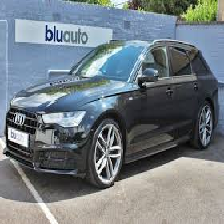

In [12]:
#loading image from test set to see how it looks
load_an_image(test_generator.filenames[4]) 

# Image Similarity function 

 *In order to find the similar images from training set, vectors has to be extracted after the flatten layer and then cosine similarity is calculated for the obtained image vector against the extracted vectors from training data. The vector having the highest cosine similarity is the similar image*

In [13]:
# Image Similarity: 
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_15 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 32)       

In [14]:
from tensorflow.keras.models import Model

# Generator for  similarity work
sim_gen = test_datagen.flow_from_directory(
    'audi_benz_bmw_train/',
    target_size=(150, 150),
    batch_size=1, shuffle=False,
    class_mode='categorical')

layer_name = 'dense_6'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

#obtaining training data vectors
intermediate_train_output = intermediate_layer_model.predict_generator(generator=sim_gen, 
                                                                 steps=707)


Found 707 images belonging to 3 classes.


In [15]:
#obtaining training data vectors
intermediate_test_output = intermediate_layer_model.predict_generator(generator=test_generator, 
                                                                 steps=15)

In [16]:
intermediate_test_output.shape

(15, 96)

In [17]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [18]:
# this function returns similar image from training data
def similar_images(find_similar):
    cos_dist = []
    for a,b in enumerate(intermediate_train_output):
        dist = cosine_similarity([find_similar],[b])
        cos_dist.append(dist)
    distance_arr = np.array(cos_dist).reshape(-1)
    similar_images =np.argsort(distance_arr)[::-1][:1]
    return similar_images
    

In [19]:
#function to load training images
def load_trained_image(file_name):
    _img = image.load_img(

        os.path.join(os.getcwd() + '\\audi_benz_bmw_train\\',  file_name)
       , 
        target_size=(224, 224)

    )
    return _img

In [20]:
#function to load test images
def load_test_image(file_name):
    _img = image.load_img(

        os.path.join(os.getcwd() + '\\audi_benz_bmw_test\\',  file_name)
       , 
        target_size=(224, 224)

    )
    return _img


In [21]:
#finding similar image of a test set image
similar_images(intermediate_test_output[11])

array([587], dtype=int64)

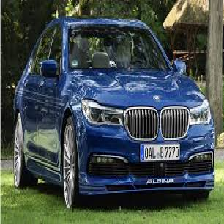

In [22]:
#loading the image to check how it looks
load_test_image(test_generator.filenames[11])

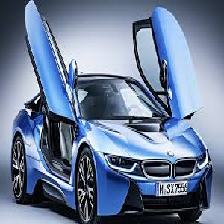

In [23]:
#Similar training image to the test image generated by the function can be seen below
load_trained_image(sim_gen.filenames[587])

# Infering the URLs and generating similar images

In [24]:
#  function to download images and temporarily store them for inference 
def download_urls(urls):
    for index, url in enumerate(urls):
        with urllib.request.urlopen(url) as url:
            save_path = os.getcwd() 
            completeName = os.path.join(save_path, 'temp_urls\\'+ str(index)+'\\'+str(index) +'.jpg')         
            with open( completeName, 'wb') as f:
                f.write(url.read())


*Downloading the images from the urls. Running the cell each time downloads new images as the urls give random new images*

In [25]:
urls = ['https://source.unsplash.com/random/?car,audi', 
        'https://source.unsplash.com/random/?car,mercedes', 
        'https://source.unsplash.com/random/?car,bmw']
download_urls(urls)

In [26]:
#loading the downloaded images 
url_gen = test_datagen.flow_from_directory('temp_urls/',
                                           target_size=(150, 150),
                                           batch_size=1, shuffle=False,
                                           class_mode='categorical')

Found 3 images belonging to 3 classes.


In [27]:
#function to display downloaded images
def load_image_from_urls(file_name):
    _img = image.load_img(

        os.path.join(os.getcwd() + '\\temp_urls\\',  file_name)
       , 
        target_size=(224, 224)

    )
    return _img

image from URL 1


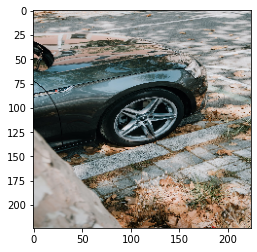

image from URL 2


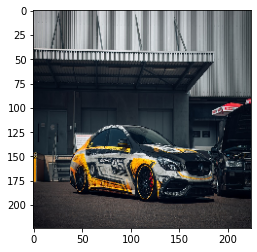

image from URL 3


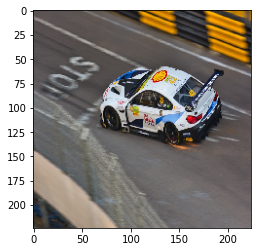

In [28]:
#displayng downloaded images 
for index in range(len(url_gen.filenames)):
    print('image from URL {}'.format(index+1))
    im=load_image_from_urls(url_gen.filenames[index])
    plt.imshow(im)
    plt.show()

### Matching probabilities

In [29]:
car_predictions = model.predict_generator(generator=url_gen, steps=3)

np.set_printoptions(suppress=True)
car_predictions = car_predictions*100

for index,prediction in enumerate(car_predictions):
    print('car predictions for Image {}: \n Audi:{}% \n Benz:{}% \n Bmw:{}%\n'.format(index+1,
                                                                np.array2string(prediction[0]),
                                                                   np.array2string(prediction[1]),
                                                                   np.array2string(prediction[2])))
    

car predictions for Image 1: 
 Audi:56.654263% 
 Benz:16.814833% 
 Bmw:26.530903%

car predictions for Image 2: 
 Audi:99.99667% 
 Benz:0.00318767% 
 Bmw:0.00014436%

car predictions for Image 3: 
 Audi:20.233011% 
 Benz:57.400143% 
 Bmw:22.366842%



### Most similar image from training data

Similar Car from training data for image from URL 1


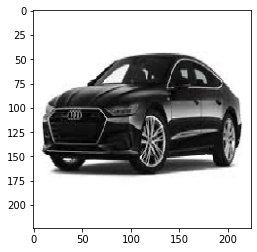

Similar Car from training data for image from URL 2


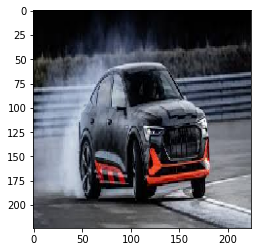

Similar Car from training data for image from URL 3


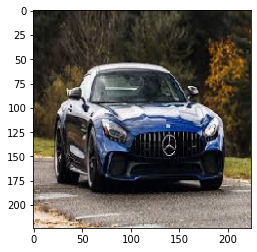

In [30]:
#obtaining vectors after flatten layer
intermediate_url_output = intermediate_layer_model.predict_generator(generator=url_gen, 
                                                                 steps=3)
#obtaining similar images using function
similar_cars_url = [similar_images(x)for x in intermediate_url_output]
similar_cars_url=np.array(similar_cars_url).reshape(-1)
ims_1 = [load_trained_image(sim_gen.filenames[x]) for x in similar_cars_url]

#displaying most similar image
for index,value in enumerate(ims_1):
    print('Similar Car from training data for image from URL {}'.format(index+1))
    plt.imshow(value)
    plt.show()